In [92]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 


In [5]:
df = pd.read_csv("labeled_data.csv")

In [6]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


Class --> 0 "hate speech " , ---> 1 "Offecive Lang " , ----> 2 "neither"

In [26]:
final_df = df[["tweet" , "class"]]

In [27]:
final_df

,tweet,class
0,!!! RT @mayasolovely: As a woman you shouldn't...,2
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,1
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,1
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,1
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,1
...,...,...
24778,you's a muthaf***in lie &#8220;@LifeAsKing: @2...,1
24779,"you've gone and broke the wrong heart baby, an...",2
24780,young buck wanna eat!!.. dat nigguh like I ain...,1
24781,youu got wild bitches tellin you lies,1


In [28]:
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove special characters, punctuation, and digits using regex
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters and punctuation

    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the tokens back into a single string
    clean_text = ' '.join(tokens)

    return clean_text


In [29]:
final_df["cleaned_tweets"] = final_df["tweet"].apply(clean_text)

C:\Users\Vaidik\AppData\Local\Temp\ipykernel_17796\1449278376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["cleaned_tweets"] = final_df["tweet"].apply(clean_text)


# Vectorization 

In [42]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
import tensorflow as tf

# Assuming final_df["cleaned_tweets"] contains the cleaned text data
# Assuming final_df["label"] contains the labels

# Convert text data to a list
text_data = final_df["cleaned_tweets"].tolist()
labels = final_df["class"].tolist()

# Encode the labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust the max_features parameter

# Fit the vectorizer and transform the text data into TF-IDF vectors
tfidf_vectors = tfidf_vectorizer.fit_transform(text_data)

nonzero_indices = np.transpose(tfidf_vectors.nonzero())
sparse_tfidf_vectors = tf.sparse.SparseTensor(indices=nonzero_indices,
                                              values=tfidf_vectors.data,
                                              dense_shape=tfidf_vectors.shape)
# Reorder the sparse tensor
sparse_tfidf_vectors_reordered = tf.sparse.reorder(sparse_tfidf_vectors)

# Convert the reordered sparse tensor back to a dense tensor
tfidf_vectors_reordered_dense = tf.sparse.to_dense(sparse_tfidf_vectors_reordered)

# Convert TF-IDF vectors to NumPy arrays
X_tfidf_numpy = tfidf_vectors_reordered_dense.numpy()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_numpy, encoded_labels, test_size=0.2, random_state=42)

# Convert labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Build the neural network model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)


Epoch 1/10


620/620 [==============================] - 10s 12ms/step - loss: 0.3862 - accuracy: 0.8619 - val_loss: 0.3085 - val_accuracy: 0.8899
Epoch 2/10
620/620 [==============================] - 7s 11ms/step - loss: 0.2666 - accuracy: 0.9022 - val_loss: 0.3108 - val_accuracy: 0.8925
Epoch 3/10
620/620 [==============================] - 7s 11ms/step - loss: 0.2355 - accuracy: 0.9161 - val_loss: 0.3143 - val_accuracy: 0.8894
Epoch 4/10
620/620 [==============================] - 7s 11ms/step - loss: 0.2084 - accuracy: 0.9243 - val_loss: 0.3320 - val_accuracy: 0.8911
Epoch 5/10
620/620 [==============================] - 7s 11ms/step - loss: 0.1740 - accuracy: 0.9351 - val_loss: 0.3751 - val_accuracy: 0.8880
Epoch 6/10
620/620 [==============================] - 7s 11ms/step - loss: 0.1432 - accuracy: 0.9477 - val_loss: 0.4219 - val_accuracy: 0.8892
Epoch 7/10
620/620 [==============================] - 7s 11ms/step - loss: 0.1171 - accuracy: 0.9552 - val_loss: 0.4293 - val_accuracy: 0.8

In [43]:
# Save the trained model
model.save('Hate_Speech_Detection.h5')


C:\Users\Vaidik\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# vectorization with Word2Vec

In [118]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Load or train your Word2Vec model
# word2vec_model = Word2Vec(...)

# Assuming final_df["cleaned_tweets"] contains the cleaned text data
# Assuming final_df["class"] contains the labels

# Convert text data to a list
text_data = final_df["cleaned_tweets"].tolist()
labels = final_df["class"].tolist()

# Tokenize text data
tokenized_data = [word_tokenize(text.lower()) for text in text_data]

# Vectorize text data using Word2Vec
word_vectors = []
for text in tokenized_data:
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        text_vector = np.mean(vectors, axis=0)  # Average the word vectors for the document
        word_vectors.append(text_vector)
    else:
        word_vectors.append(np.zeros(word2vec_model.vector_size))  # Use zero vector if no word in vocabulary

# Convert lists to numpy arrays
X = np.array(word_vectors)
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoded vectors
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Build the neural network model
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)
from sklearn.metrics import confusion_matrix

# Get the predictions for the test set
y_pred = model.predict_classes(X_test)

# Convert one-hot encoded y_test back to categorical labels
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(conf_matrix)




Epoch 1/10
620/620 [==============================] - 6s 7ms/step - loss: 0.5985 - accuracy: 0.7831 - val_loss: 0.5805 - val_accuracy: 0.7914
Epoch 2/10
620/620 [==============================] - 4s 6ms/step - loss: 0.5851 - accuracy: 0.7880 - val_loss: 0.5838 - val_accuracy: 0.7898
Epoch 3/10
620/620 [==============================] - 4s 6ms/step - loss: 0.5820 - accuracy: 0.7892 - val_loss: 0.5699 - val_accuracy: 0.7908
Epoch 4/10
620/620 [==============================] - 3s 5ms/step - loss: 0.5762 - accuracy: 0.7894 - val_loss: 0.5723 - val_accuracy: 0.7898
Epoch 5/10
620/620 [==============================] - 3s 5ms/step - loss: 0.5760 - accuracy: 0.7895 - val_loss: 0.5670 - val_accuracy: 0.7920
Epoch 6/10
620/620 [==============================] - 4s 6ms/step - loss: 0.5722 - accuracy: 0.7881 - val_loss: 0.5819 - val_accuracy: 0.7908
Epoch 7/10
620/620 [==============================] - 4s 6ms/step - loss: 0.5698 - accuracy: 0.7887 - val_loss: 0.5658 - val_accuracy: 0.7922
Epoch 

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [45]:
model.save("Hate_Speech_Detection_w2v.h5")

In [46]:
word2vec_model.save("word2vec_model.bin")

In [68]:
df[df["class"] == 0]["tweet"].to_list()[6]

'"@RTNBA: Drakes new shoes that will be released by Nike/Jordan.... Yes, there\'s glitter on the shoes http://t.co/QCtPLxHEXM" ....dudes a fag'

In [69]:
df

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...,...
24778,25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
24780,25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [72]:
len(final_df[final_df["class"] == 0].values)

1430

In [73]:
len(final_df[final_df["class"] == 1].values)

19190

In [74]:
len(final_df[final_df["class"] == 2].values)

4163

In [75]:
#REdist of data

mask_mid = final_df[final_df["class"] == 1]

In [79]:
df_mid = mask_mid.sample(1500)

In [80]:
mask_last = final_df[final_df["class"] == 2]

df_last = mask_last.sample(1500)

In [81]:
#REdist of data

mask_1 = final_df[final_df["class"] == 0]



In [83]:
train_df = pd.concat([df_mid , df_last , mask_1])

In [84]:
train_df.shape

(4430, 3)

,tweet,class,cleaned_tweets
2949,@Dalton_ryann @parkatie @blakeanderson21 I gue...,1,dalton_ryann parkatie blakeanderson guess dumb...
17144,RT @Runyacheckup: Niggas and bitches gotta qui...,1,rt runyacheckup nigga bitch got ta quit wit da...
20183,RT @thtsher__: if ya bitch mad tell ha I'll pu...,1,rt thtsher__ ya bitch mad tell ha ill put ha
6399,@kieffer_jason @C_janacek07 nigga stop being a...,1,kieffer_jason c_janacek nigga stop bitch come ...
4316,@OLE_VertyBstard @thereal_EMandM @Holt3 lay in...,1,ole_vertybstard thereal_emandm holt lay brothe...
...,...,...,...
24576,this guy is the biggest faggot omfg,0,guy biggest faggot omfg
24685,which one of these names is more offensive kik...,0,one name offensive kike wop kraut wetback jiga...
24751,you a pussy ass nigga and I know it nigga.,0,pussy as nigga know nigga
24776,you're all niggers,0,youre nigger


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_148 (Dense)           (None, 512)               51712     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_149 (Dense)           (None, 512)               262656    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_150 (Dense)           (None, 512)               262656    
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_151 (Dense)           (None, 512)             

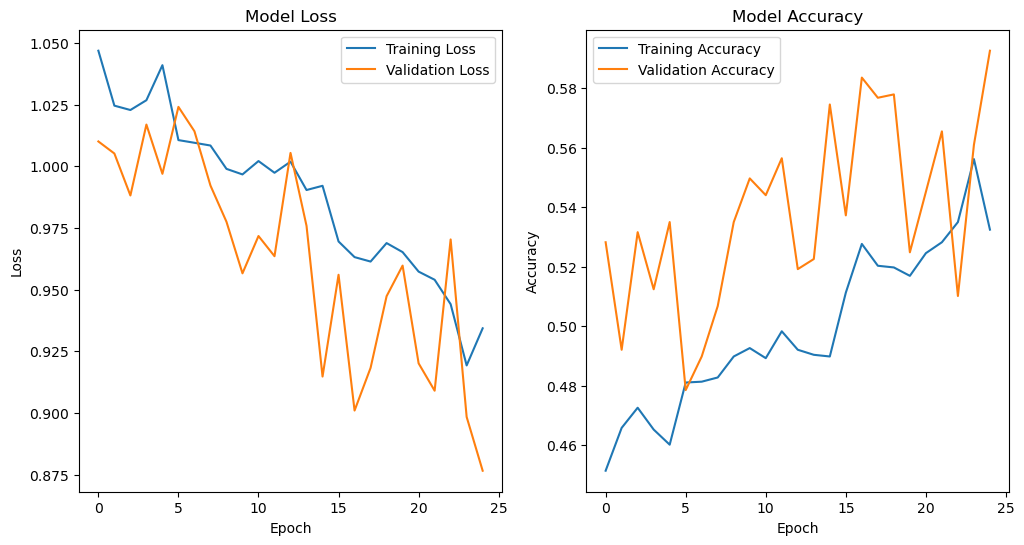

In [132]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# Load or train your Word2Vec model
# word2vec_model = Word2Vec(...)

# Assuming final_df["cleaned_tweets"] contains the cleaned text data
# Assuming final_df["class"] contains the labels

# Convert text data to a list
text_data = train_df["cleaned_tweets"].tolist()
labels = train_df["class"].tolist()

# Tokenize text data
tokenized_data = [word_tokenize(text.lower()) for text in text_data]

# Vectorize text data using Word2Vec
word_vectors = []
for text in tokenized_data:
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        text_vector = np.mean(vectors, axis=0)  # Average the word vectors for the document
        word_vectors.append(text_vector)
    else:
        word_vectors.append(np.zeros(word2vec_model.vector_size))  # Use zero vector if no word in vocabulary

# Convert lists to numpy arrays
X = np.array(word_vectors)
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoded vectors
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
from keras.layers import LeakyReLU

# Build the neural network model with LeakyReLU activation
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],)))
model.add(LeakyReLU(alpha=0.9))# You can adjust the value of alpha as per your requirement
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.9))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.9))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.9))
model.add(Dense(512))
model.add(LeakyReLU(alpha=0.3))
model.add(Dense(num_classes, activation='sigmoid'))  # Output layer

model.summary()


# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

#import matplotlib.pyplot as plt

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Accuracy:", accuracy)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [107]:
word_vectors[0]

array([-0.02696836,  0.10805003,  0.03407477,  0.03298609,  0.03486539,
       -0.11589476,  0.0361025 ,  0.19220868, -0.04932994, -0.07619129,
       -0.01300244, -0.14382893, -0.01908199,  0.04507047,  0.04333741,
       -0.05203537,  0.07401676, -0.09299529, -0.01888881, -0.17421605,
        0.06405089,  0.02627363,  0.1084075 , -0.07273944,  0.01030289,
        0.03482196, -0.05995315, -0.02832519, -0.04863849,  0.05456959,
        0.09400566, -0.00063756,  0.03791746, -0.1054239 , -0.02017355,
        0.10532294,  0.00473386, -0.07178858, -0.0566791 , -0.11361964,
        0.05761714, -0.09208843, -0.02988708, -0.00280581,  0.0723057 ,
        0.00033006, -0.08246565, -0.04076908,  0.02361031,  0.0892459 ,
        0.04474258, -0.11975547, -0.02739194, -0.04810824, -0.05208719,
        0.06416262,  0.06242287,  0.01869947, -0.05006192,  0.04342727,
       -0.01787626, -0.01152599, -0.0062931 , -0.00343945, -0.08670525,
        0.11522547,  0.06318715,  0.06091146, -0.10173897,  0.10

In [108]:
train_df.shape

(4430, 3)

In [119]:
from sklearn.svm import SVC

# Transform the data into suitable format for SVM
# For SVM, we can use the same word vectors X and one-hot encoded labels y

# Train the SVM model
svm_model = SVC(kernel='linear')  # You can choose different kernels like 'rbf', 'poly', etc.
svm_model.fit(X_train, np.argmax(y_train, axis=1))  # Convert one-hot encoded labels back to categorical labels for SVM

# Evaluate the SVM model
svm_accuracy = svm_model.score(X_test, np.argmax(y_test, axis=1))  # Convert one-hot encoded labels back to categorical labels for evaluation

print("SVM Test Accuracy:", svm_accuracy)


SVM Test Accuracy: 0.7730482146459552


In [126]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Convert text data to a list
text_data_train = train_df["cleaned_tweets"].tolist()
text_data_test = train_df["cleaned_tweets"].tolist()

# Convert labels to numpy arrays
y_train = np.array(train_df["class"])
y_test = np.array(train_df["class"])

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(text_data_train)

# Transform the test data into TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(text_data_test)

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_nb = nb_classifier.predict(X_test_tfidf)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, y_pred_nb)

print("Multinomial Naive Bayes with TF-IDF Test Accuracy:", nb_accuracy)


Multinomial Naive Bayes with TF-IDF Test Accuracy: 0.9392776523702031


In [130]:
import pickle

# Save the classifier and TF-IDF vectorizer to files
with open('naive_bayes_classifier.pkl', 'wb') as file:
    pickle.dump(nb_classifier, file)

with open('tfidf_vectorizer.pkl', 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)


In [128]:
!pip install joblib

Multinomial Naive Bayes with TF-IDF Test Accuracy: 0.7562076749435666
Best Parameters: {'alpha': 10.0}
Best Cross Validation Score: 0.7499964141426215


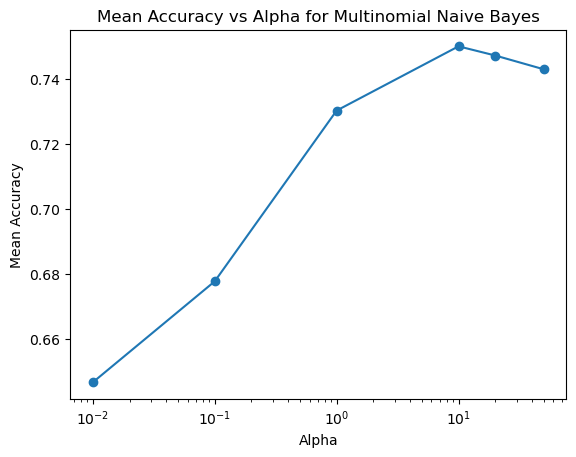

In [139]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load or create your train_df and test_df

# Convert text data to a list
text_data = train_df["cleaned_tweets"].tolist()
labels = train_df["class"].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data into TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_nb = nb_classifier.predict(X_test_tfidf)

# Calculate accuracy on the test set
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Multinomial Naive Bayes with TF-IDF Test Accuracy:", nb_accuracy)

# Perform Grid Search CV for parameter tuning
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0 , 20.0 , 50]}  # Example values for alpha
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross Validation Score:", grid_search.best_score_)

# Plotting accuracy for different values of alpha
alphas = [0.01, 0.1, 1.0, 10.0 , 20.0 , 50 ]
mean_scores = grid_search.cv_results_['mean_test_score']
plt.plot(alphas, mean_scores, '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Alpha for Multinomial Naive Bayes')
plt.xscale('log')
plt.show()


Multinomial Naive Bayes with TF-IDF Test Accuracy: 0.7865644543070406
Best Parameters: {'alpha': 0.1}
Best Cross Validation Score: 0.8455564734035009


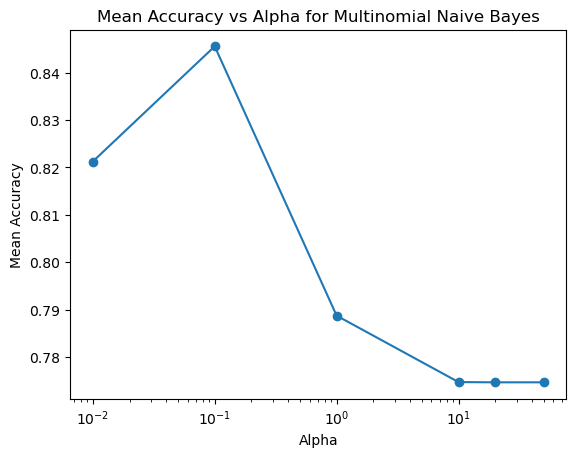

In [144]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Load or create your train_df and test_df

# Convert text data to a list
text_data = df["tweet"].tolist()
labels = df["class"].tolist()

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)

# Initialize the TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()

# Fit and transform the training data to TF-IDF features
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data into TF-IDF features
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Initialize the Multinomial Naive Bayes classifier
nb_classifier = MultinomialNB()

# Train the classifier
nb_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_nb = nb_classifier.predict(X_test_tfidf)

# Calculate accuracy on the test set
nb_accuracy = accuracy_score(y_test, y_pred_nb)
print("Multinomial Naive Bayes with TF-IDF Test Accuracy:", nb_accuracy)

# Perform Grid Search CV for parameter tuning
param_grid = {'alpha': [0.01, 0.1, 1.0, 10.0 , 20.0 , 50]}  # Example values for alpha
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross Validation Score:", grid_search.best_score_)

# Plotting accuracy for different values of alpha
alphas = [0.01, 0.1, 1.0, 10.0 , 20.0 , 50 ]
mean_scores = grid_search.cv_results_['mean_test_score']
plt.plot(alphas, mean_scores, '-o')
plt.xlabel('Alpha')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs Alpha for Multinomial Naive Bayes')
plt.xscale('log')
plt.show()


In [146]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy on the test set
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Random Forest Test Accuracy:", rf_accuracy)

Random Forest Test Accuracy: 0.8577768811781319


In [147]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the Decision Tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier
dt_classifier.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test_tfidf)

# Calculate accuracy on the test set
dt_accuracy = accuracy_score(y_test, y_pred_dt)
print("Decision Tree Test Accuracy:", dt_accuracy)


Decision Tree Test Accuracy: 0.8737139398829937


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_160 (Dense)           (None, 512)               51712     
                                                                 
 batch_normalization_5 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_161 (Dense)           (None, 512)               262656    
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_162 (Dense)           (None, 512)               262656    
                                                                 
 batch_normalization_7 (Bat  (None, 512)             

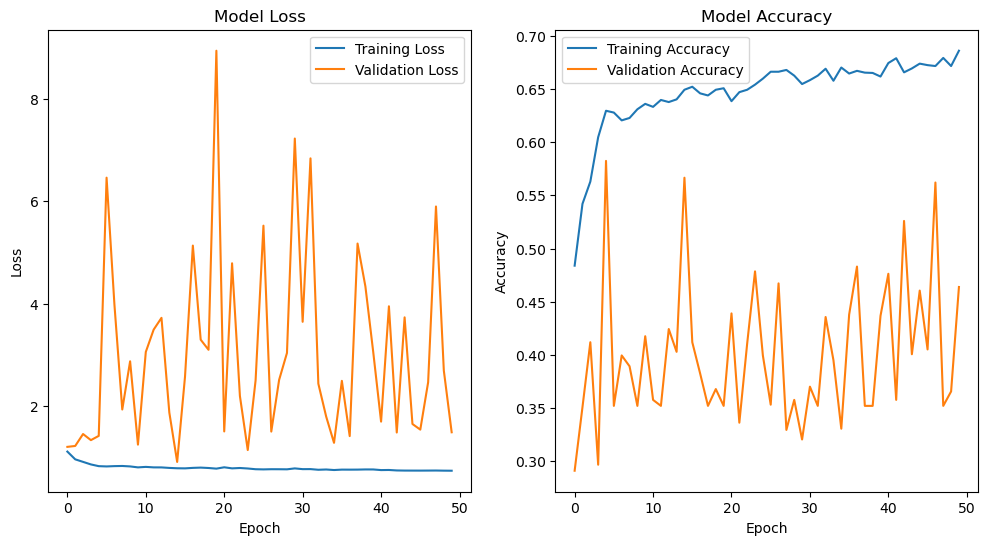

In [150]:
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

# Assuming final_df["cleaned_tweets"] contains the cleaned text data
# Assuming final_df["class"] contains the labels

# Convert text data to a list
text_data = train_df["cleaned_tweets"].tolist()
labels = train_df["class"].tolist()

# Tokenize text data
tokenized_data = [word_tokenize(text.lower()) for text in text_data]

# Vectorize text data using Word2Vec
word_vectors = []
for text in tokenized_data:
    vectors = [word2vec_model.wv[word] for word in text if word in word2vec_model.wv]
    if vectors:
        text_vector = np.mean(vectors, axis=0)  # Average the word vectors for the document
        word_vectors.append(text_vector)
    else:
        word_vectors.append(np.zeros(word2vec_model.vector_size))  # Use zero vector if no word in vocabulary

# Convert lists to numpy arrays
X = np.array(word_vectors)
y = np.array(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoded vectors
num_classes = len(np.unique(y))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Build the neural network model with BatchNormalization and ReLU activation
model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))  # Output layer

model.summary()

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Accuracy:", accuracy)

# Plot training history
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch 1/25
111/111 [==============================] - 3s 26ms/step - loss: 0.7589 - accuracy: 0.6718 - val_loss: 1.4018 - val_accuracy: 0.5135
Epoch 2/25
111/111 [==============================] - 2s 22ms/step - loss: 0.7472 - accuracy: 0.6755 - val_loss: 1.2742 - val_accuracy: 0.4345
Epoch 3/25
111/111 [==============================] - 3s 23ms/step - loss: 0.7347 - accuracy: 0.6826 - val_loss: 1.5333 - val_accuracy: 0.4278
Epoch 4/25
111/111 [==============================] - 2s 21ms/step - loss: 0.7549 - accuracy: 0.6735 - val_loss: 2.4711 - val_accuracy: 0.4255
Epoch 5/25
111/111 [==============================] - 2s 20ms/step - loss: 0.7389 - accuracy: 0.6803 - val_loss: 1.4363 - val_accuracy: 0.5914
Epoch 6/25
111/111 [==============================] - 2s 20ms/step - loss: 0.7377 - accuracy: 0.6769 - val_loss: 1.5515 - val_accuracy: 0.4368
Epoch 7/25
111/111 [==============================] - 2s 20ms/step - loss: 0.7492 - accuracy: 0.6792 - val_loss: 2.6790 - val_accuracy: 0.3567

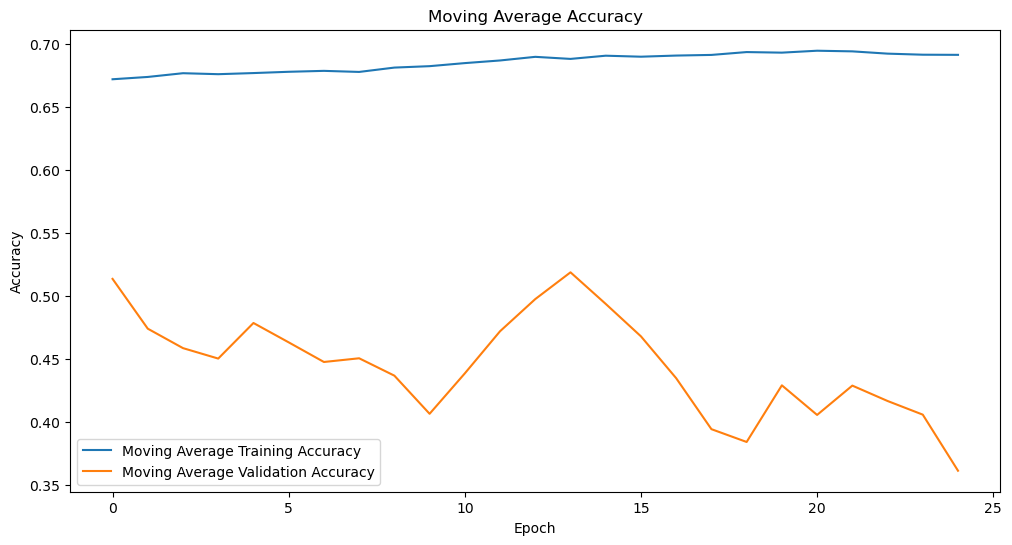

In [151]:
# Define a function to compute the moving average
def moving_average(data, window_size=5):
    moving_avg = []
    for i in range(len(data)):
        start_idx = max(0, i - window_size + 1)
        avg = np.mean(data[start_idx:i+1])
        moving_avg.append(avg)
    return moving_avg

# Train the model and store the history
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Extract accuracy values from history
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Compute moving average accuracy
window_size = 5
moving_avg_training_accuracy = moving_average(training_accuracy, window_size)
moving_avg_validation_accuracy = moving_average(validation_accuracy, window_size)

# Plot moving average accuracy
plt.figure(figsize=(12, 6))
plt.plot(moving_avg_training_accuracy, label='Moving Average Training Accuracy')
plt.plot(moving_avg_validation_accuracy, label='Moving Average Validation Accuracy')
plt.title('Moving Average Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
